In [1]:
# sudo -HE mlp-run mountainsort3.mlp sort --raw=data/raw.mda --geom=data/geom.csv --firings_out=data/firings2.mda --_params=params.json --curate=true

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import sys
sys.path.insert(0, '/mnt/cube/tsainbur/Projects/github_repos/mountainsort/packages/pyms/')
from mlpy import *

In [3]:
import sys
sys.path.insert(0, '../../../mountainsort/packages/pyms/')

In [4]:
from mlpy import *

In [5]:
sorted_spikes=DiskReadMda('data/firings_1_hr.mda')
raw=DiskReadMda('data/B1169_test_60mins.mda')
#sorted_spikes=readmda('data/firings_uncurated.mda')

In [6]:
108000000/60/60/20000

1.5

In [7]:
print(sorted_spikes.dims())

[3, 247444]


In [8]:
print(raw.dims())

[32, 72000000]


In [9]:
rate = fs= 20000

In [10]:
#np.shape(raw)

In [11]:
#seconds = np.shape(raw)[1]/rate
#print('Dataset length: ',seconds, ' seconds')

In [12]:
sample_neural_data = raw.readChunk(i1=0,i2=0,N1=32,N2=30000).T
print(np.shape(sample_neural_data))

(30000, 32)


In [13]:
def norm(X):
    return (X - np.min(X)) / (np.max(X)- np.min(X))

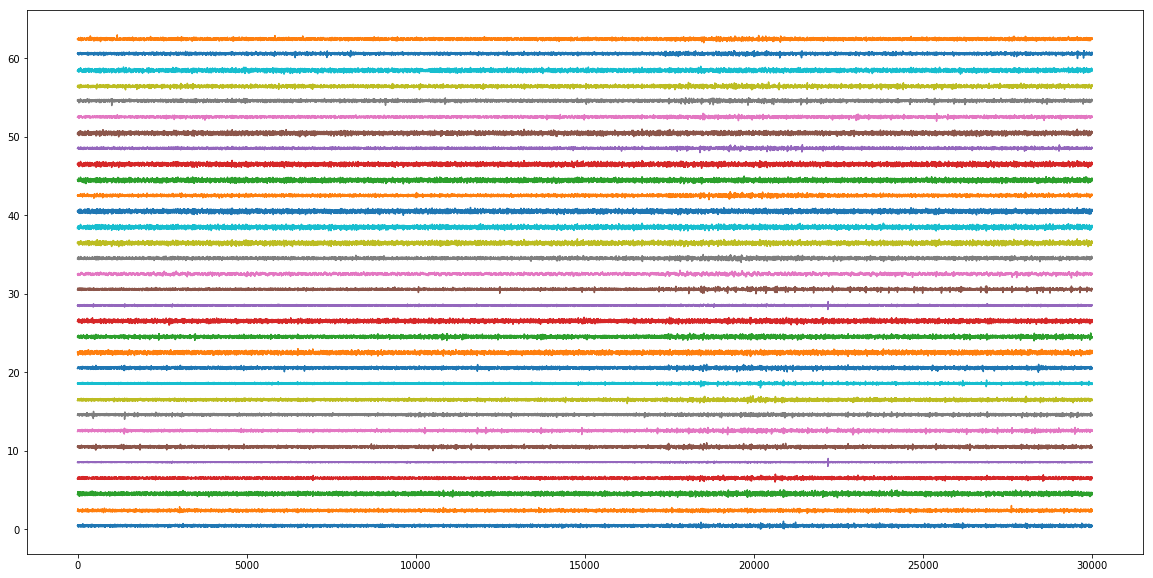

In [14]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20, 10))
for i in range(np.shape(sample_neural_data)[1]):
    plt.plot(norm(sample_neural_data[:,i])+i*2)

In [15]:
from scipy.io import wavfile

In [16]:
len(wavfile.read('/mnt/cube/tsainbur_raw/B1169/Tim2_stims (1)/resampled/data/g_6/-0d15625_-0d15625.wav')[1])

40171

In [17]:
sorted_spikes.dims()

[3, 247444]

In [18]:
spike_sample = sorted_spikes.readChunk(i1=0,i2=0,N1=3,N2=100).T
print(np.shape(spike_sample))

(100, 3)


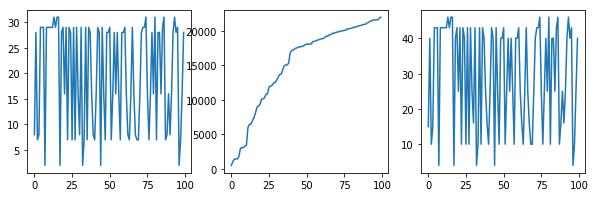

In [19]:
fig, ax = plt.subplots(ncols=3, nrows = 1, figsize=(10,3))
ax[0].plot(spike_sample[:,0])
ax[1].plot(spike_sample[:,1])
ax[2].plot(spike_sample[:,2])

In [20]:
rate = 20000 
time_len = .005

In [21]:
cluster = 2

In [22]:
# sorted_spikes 0: channel, 1: sample number, 2: cluster number

In [23]:
np.shape(raw.readChunk(i1=0,i2=0,N1=32,N2=30000))

(32, 30000)

In [24]:
all_spikes = sorted_spikes.readChunk(i1=0,i2=0,N1=sorted_spikes.dims()[0],N2=sorted_spikes.dims()[1])
np.shape(all_spikes)

(3, 247444)

In [25]:
np.max(all_spikes[1,])/rate/60

59.998903333333338

In [26]:
len(np.unique(all_spikes[2]))

15

2.0 1 [ 89557.  90281.  92822.]


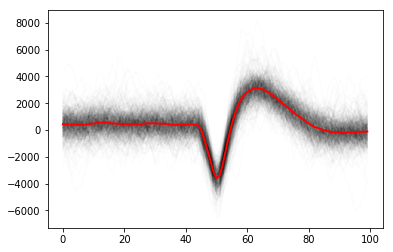

In [27]:
for cluster in np.unique(all_spikes[2]):
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(6, 4))
    cluster_spikes = np.where(all_spikes[2] == cluster)[0]
    cluster_channel = int(all_spikes[0][cluster_spikes][0])
    print(cluster, cluster_channel,all_spikes[1][cluster_spikes][:3])
    asw = []
    for i, cs in enumerate(cluster_spikes):
        spike_time_sample = int(all_spikes[1][cs])
        window = [spike_time_sample - int(rate*time_len/2), spike_time_sample + int(rate*time_len/2)]
        #print(breakme)
        spike_window = raw.readChunk(i1=0,i2=window[0],N1=32,N2=window[1] - window[0])[cluster_channel-1]
        #print(spike_window)
        if len(spike_window) != 100:break
        asw.append(spike_window)
        plt.plot(spike_window, color = 'k', alpha = .01)
        
        if i ==500:break
    plt.plot(np.mean((asw), axis = 0), color='red',lw=2)
    plt.show()
    break


In [28]:
time_to_sample = 1
samps_to_samp = int(time_to_sample*rate)

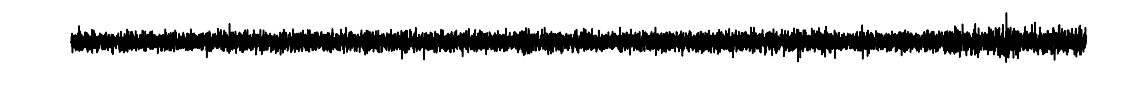

In [29]:
for cluster in np.unique(all_spikes[2]):
    cluster_spikes = np.where(all_spikes[2] == cluster)[0]
    cluster_channel = int(all_spikes[0][cluster_spikes][0])
    channel_sample = raw.readChunk(i1=0,i2=0,N1=32,N2=samps_to_samp)[cluster_channel-1,:]
    
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20, 1))
    plt.plot(norm(channel_sample), color='k')

    for i, cs in enumerate(cluster_spikes):
        if all_spikes[1][cs] > samps_to_samp:
            continue
        ax.axvline(all_spikes[1][cs], ls='solid', color='red', ymin=.75, ymax=1)
    plt.axis('off')
    plt.show()
    break


In [60]:
def get_textmark(char_array):
    return ''.join([chr(xi) for xi in char_array]).replace('\x00', '')

def load_stim_info(s2mat):
    try:
        with h5py.File(s2mat, 'r') as f:
            times = np.array(f['stimulus_textmark']['times']).T.squeeze()
            codes = np.array([c for c in f['stimulus_textmark']['codes'][0,:]])
            names = np.array([get_textmark(x) for x in np.transpose(f['stimulus_textmark']['text'])])
    except KeyError:
        with h5py.File(s2mat, 'r') as f:
            times = np.array(f['stimulus_']['times']).T.squeeze()
            codes = np.array([c for c in f['stimulus_']['codes'][0,:]])
            names = np.array([get_textmark(x) for x in np.transpose(f['stimulus_']['text'])])

    assert len(codes)==len(times)
    assert len(codes)==len(names)
    return codes, times, names
def load_digmark(s2mat):
    with h5py.File(s2mat, 'r') as f:
        times = np.array(f['DigMark']['times']).T.squeeze()
        codes = np.array([str(chr(c)) for c in f['DigMark']['codes'][0,:]])
    assert len(codes)==len(times)
    return codes, times

In [32]:
mat_file = '/mnt/cube/tsainbur/Experiments/ephys_analysis/B1169/matfiles/Pen01_Lft_AP2500_ML500__Site01_Z1450__B1169_cat_P01_S01_1/SubB1169Pen00Site01Epc07File01_11-22-17+09-49-24_B1169_block.mat'

In [68]:
codes, times, names = load_stim_info(mat_file)
times = (times * rate).round().astype(np.uint64)
trials = pd.DataFrame(np.array([codes, names, times]).T, columns = ['codes', 'stimulus', 'time_samples'])
trials[:10]

,codes,stimulus,time_samples
0,243,date_2017-11-22+09-49-24_filetime_0.007899,158
1,244,6.266499,125330
2,0,-3d984375_2d421875,125330
3,244,8.537199,170744
4,73,-3d671875_-5d859375,170744
5,244,10.826099,216522
6,73,-2d734375_-14d296875,216522
7,244,13.032149,260643
8,202,-2d890625_-0d390625,260643
9,244,15.076599,301532


In [69]:
codes, times = load_digmark(mat_file)
times = (times * rate).round().astype(np.uint64)


In [70]:
len(codes), len(times)

(10684, 10684)

In [71]:
digimark = pd.DataFrame(np.array([codes, times]).T, columns = ['codes', 'time_samples'])

In [72]:
digimark[:10]

,codes,time_samples
0,<,124985
1,>,145070
2,(,145072
3,),162054
4,<,170043
5,>,190129
6,(,190130
7,),209140
8,<,216055
9,>,236141


In [74]:
trials_spaces = trials[trials.codes == '244']
trials_spaces['stimulus'] = (trials_spaces['stimulus'].values.astype('float64')  * rate).round().astype(np.uint64)

trials_spaces.index = trials_spaces.index - 1
trials_spaces[:3]

ValueError: could not convert string to float: '-4d296875_-1d484375'

In [36]:
trials = trials[trials.codes != '244']
trials['stimulus_end'] = trials_spaces['time_samples']
trials['recording'] = 0
trials=trials[1:-1]
trials['stim_points'] = [[float(j.replace("d", ".")) for j in i.split('_')] for i in list(trials['stimulus'])]
trials = trials.reset_index(drop=True)

In [37]:
trials[:3]

,codes,stimulus,time_samples,stimulus_end,recording,stim_points
0,0,-3d984375_2d421875,125330,170744,0,"[-3.984375, 2.421875]"
1,73,-3d671875_-5d859375,170744,216522,0,"[-3.671875, -5.859375]"
2,73,-2d734375_-14d296875,216522,260643,0,"[-2.734375, -14.296875]"


In [ ]:
trials['time_samples'] = trials['time_samples'].values.astype('int32')
trials['stimulus_end'] = trials['stimulus_end'].values.astype('int32')

In [ ]:
spikes = pd.DataFrame(all_spikes.T, columns = ['channel', 'time_samples', 'cluster'])
spikes['recording'] = 0
spikes['cluster'] = spikes['cluster'].astype('int32')
spikes['channel'] = spikes['cluster'].astype('int32')
spikes['time_samples'] = spikes['time_samples'].astype('int32')

In [ ]:
spikes[:3]

In [ ]:
trials['x_loc'] = np.array(list(trials['stim_points']))[:,0]
trials['y_loc'] = np.array(list(trials['stim_points']))[:,1]

In [ ]:
trials[:3]

In [ ]:
mat_data = h5py.File(mat_file, 'r')
aud_stims = mat_data['Aud__Stim_']['values']

In [ ]:
ss = trials.loc[0]['time_samples']
se = trials.loc[0]['stimulus_end']

In [ ]:
plt.plot((np.squeeze(aud_stims[:,ss:se])))

In [ ]:
plt.scatter(trials['x_loc'], trials['y_loc'], s=1)

In [ ]:
np.max(spikes['time_samples'])

In [ ]:
import sys
sys.path.append('/mnt/cube/tsainbur/Experiments/ephys_analysis/ephys-analysis/')
from ephys import rasters, core, events

In [ ]:
clusterID = 1
raster_window = [-2, 2]

In [ ]:
stim = '-3d984375_2d421875'

In [ ]:
nrows= 4
ncols = 4
f, pltaxes = plt.subplots(nrows, ncols, sharey=True, figsize=(ncols*4,nrows*2))
rec = 0
for ind, clusterID in enumerate(tqdm(np.sort(np.unique(spikes['cluster']))[:nrows*ncols])):

    ax = pltaxes.flatten()[ind]
    rasters.plot_raster_cell_stim(spikes, trials, clusterID, stim, 
                                  raster_window, rec, rate, ax=ax)
    ax.set_title('Cell: {} Stim: {}'.format(clusterID, stim))


In [ ]:
def create_gauss_psth(stimuli,fs, clusterID, period= [-1, 1], rec=0, hist_window_ms = 5, gaussian_sigma_ms = 2000):
    """ 
    """
    stim_trials = trials[trials['stimulus']==stim]
    ntrials = len(stim_trials)
    stim_starts = stim_trials['time_samples'].values
    stim_ends = stim_trials['stimulus_end'].values
    stim_end_seconds = np.unique((stim_ends - stim_starts)/fs)[0]
    window = [period[0], stim_end_seconds+period[1]]
    raster_data = []
    for trial, start in enumerate(stim_starts):
        sptrain = rasters.get_spiketrain(rec, start, clusterID, spikes, window, fs)
        raster_data.append(sptrain)
    histogrammed_spikes = np.histogram(np.concatenate(raster_data),bins = np.arange(window[0], window[1], hist_window_ms/1000.))[0]
    #print(gaussian_sigma_ms,hist_window_ms)
    gauss_psth = gaussian_filter(histogrammed_spikes.astype('float32'),gaussian_sigma_ms/hist_window_ms)
    return gauss_psth

In [ ]:
gauss_line = create_gauss_psth(stimuli = stim,fs=fs, clusterID=clusterID , period= [-1, 1], rec=0, hist_window_ms = 5, gaussian_sigma_ms = 20)
plt.plot(gauss_line, color='k')

In [ ]:
subsample = trials[trials.x_loc == -3.984375].sort_values('y_loc')

In [ ]:
len(subsample.stimulus)

In [ ]:
for clusterID in np.unique(spikes.cluster):
    gauss_lines = [create_gauss_psth(stimuli = stim,fs=fs, clusterID=clusterID , period= [-1, 1], rec=0, hist_window_ms = 5, gaussian_sigma_ms = 20) for stim in tqdm(list(subsample.stimulus))]
    plt.matshow(gauss_lines)
    plt.show()